# Linear Regression (Gradient Descent)





So far we have looked at direct matrix method for solving the $Ax = b$ problem. But most machine learning algorithms may not be directly computatable. So the alternative way to do is to define a cost function that needs to be minimised and use a gradient descent approach to solve it.

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
pop = pd.read_csv('data/cars_small.csv')

In [7]:
pop.head()

,brand,model,price,kmpl,bhp,type
0,Chevrolet,Beat,421,18.6,79,Hatchback
1,Chevrolet,Sail,551,18.2,82,Sedan
2,Chevrolet,Sail Hatchback,468,18.2,82,Hatchback
3,Chevrolet,Spark,345,16.2,62,Hatchback
4,Fiat,Linea Classic,612,14.9,89,Sedan


Lets explore this more through our Linear Regression lens

$$ price = 1158 - 36 * kmpl ~~~~ \textit{(population = 42)}$$ 


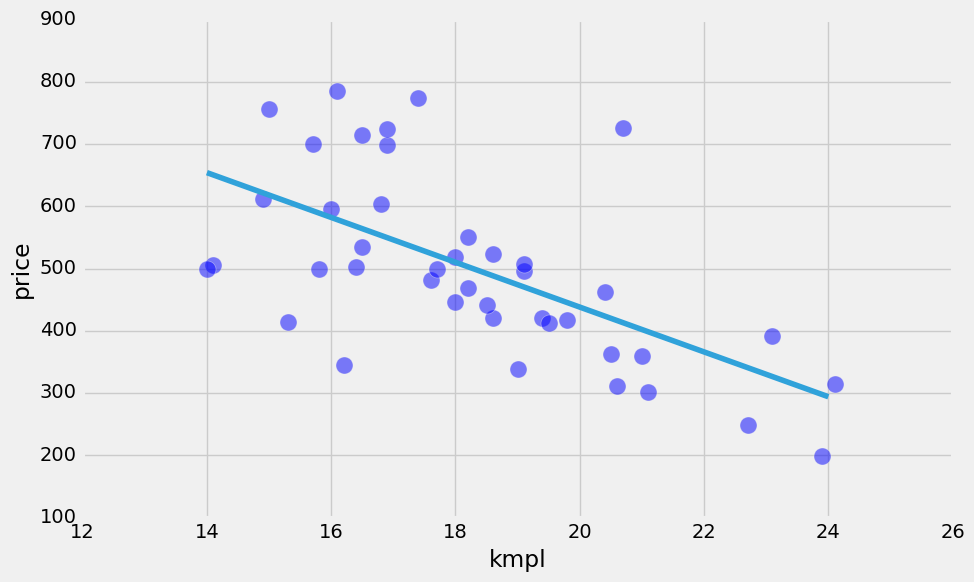

In [8]:
beta_0_p, beta_1_p = 1158, -36 
x = np.arange(min(pop.kmpl),max(pop.kmpl),1)

plt.xlabel('kmpl')
plt.ylabel('price')

y_p = beta_0_p + beta_1_p * x
plt.plot(x, y_p, '-')
plt.scatter(pop.kmpl, pop.price, s = 150, alpha = 0.5 )

The error term as we saw is defined as:

$$ E(\beta)=   \frac {1}{n} {||y - X\beta||}^2 $$

Let us understand the shape of the error term

In [9]:
n = pop.shape[0]

In [10]:
x0 = np.ones(n)
x1 = pop.kmpl
X = np.c_[x0, x1]

In [11]:
X = np.asmatrix(X)
y = np.asmatrix(pop.price.values.reshape(-1,1))
b = np.asmatrix([[1158],
                 [-36]])

In [12]:
# Error calculation
def error(X,y,b,n):
    M = (y - X*b)
    error = M.T*M / n
    return error[0,0]

In [13]:
error(X,y,b,n)

13064.720952380952

Lets plot the shape of the error term

In [15]:
b0_min, b0_max = -500, 2000
b1_min, b1_max = -100, 100
bb0, bb1 = np.meshgrid(np.arange(b0_min, b0_max, (b0_max - b0_min)/100), 
                       np.arange(b1_min, b1_max, (b1_max - b1_min)/100))

In [16]:
bb = np.c_[bb0.ravel(), bb1.ravel()]

In [17]:
e = [error(X,y,np.asmatrix(i).T,n) for i in bb]

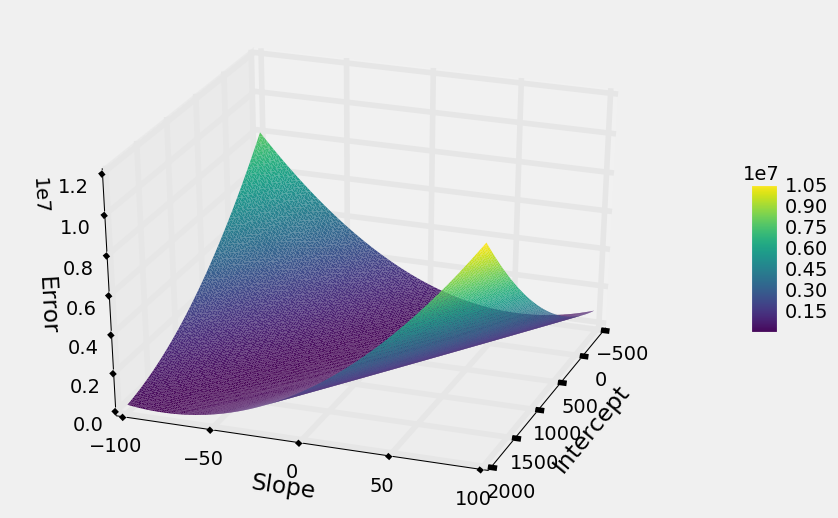

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
trisurf = ax.plot_trisurf(bb[:,0], bb[:,1], e, cmap=plt.cm.viridis, linewidth=0)

ax.view_init(azim=20)
fig.colorbar(trisurf, shrink=0.3, aspect=5)

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel("Error")

We can see that the error surface is CONVEX. And there is one absolute minimum point. Let's see the same thing as a contour plot and make it more clear.

In [20]:
Z = np.asmatrix(e).reshape(bb0.shape)

In [21]:
e_min, e_max = np.min(e), np.max(e)
e_min, e_max

(13088.873333333331, 10815041.217142858)

In [22]:
levels = np.logspace(np.log10(e_min), np.log10(e_max), 30)

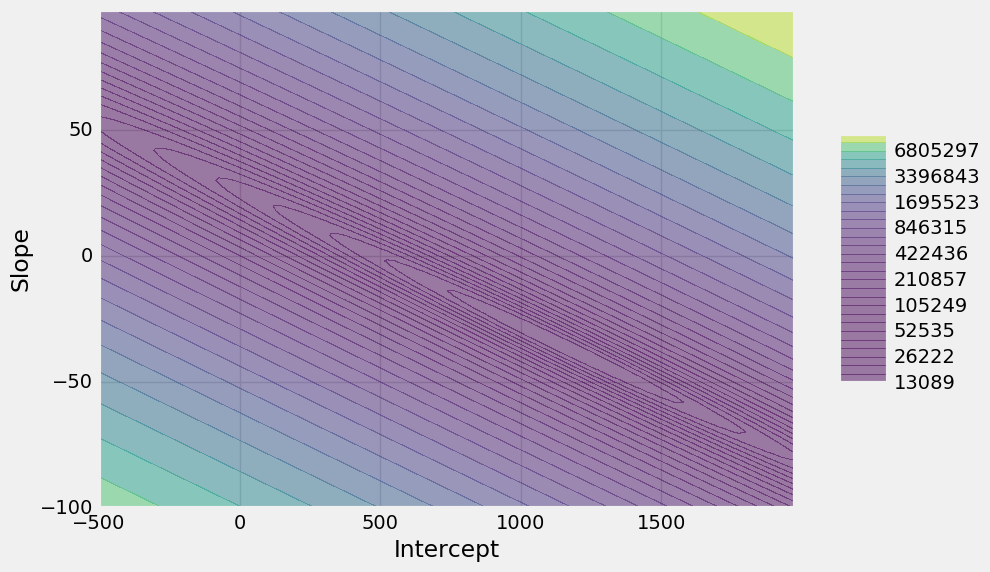

In [23]:
fig = plt.figure()
cs = plt.contourf(bb0, bb1, Z, cmap=plt.cm.viridis, levels = levels, linewidth=0.3, alpha = 0.5)
fig.colorbar(cs, shrink=0.5, aspect=5)

plt.xlabel('Intercept')
plt.ylabel('Slope')

## Gradient Descent 

In our linear regression problem, there is only one minimum. Our error surface is convex. So we can start from one point on the error surface and gradually move down in the error surface in the direction of the minimum.

"At a theoretical level, gradient descent is an algorithm that minimizes the cost functions. Given a cost function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the cost function. This iterative minimization is achieved using calculus, taking steps in the negative direction of the function gradient."

So the gradient in linear regression is:
$$ \nabla E(\beta)=  \frac {2}{n} X^T(X\beta−y) $$

Lets start at an arbitary point for the features (0,0) and calculate the gradient




In [24]:
b_initial = np.asmatrix([[1158],
                      [-36]])

In [25]:
def gradient(X,y,b,n):
    g = (2/n)*X.T*(X*b - y)
    return g

In [26]:
error(X,y,b_initial,n)

13064.720952380952

In [27]:
gradient(X,y,b_initial,n)

matrix([[  4.98095238],
        [ 92.64857143]])

In [28]:
b = b_initial - 0.01 * gradient(X,y,b_initial,n)
b

matrix([[ 1157.95019048],
        [  -36.92648571]])

## Learning Rate and Epochs

Now we need to update our parameters in the direction of the gradient. And keep repeating the process. 

$$ \beta_{i+1} = \beta_{i} - \eta * \nabla E(\beta)$$


- Learning rate ($\eta$) - how far we need to move towards the gradient in each step
- Epoch - Number of times we want to execute this process

In [29]:
def gradient_descent (eta, epochs, X, y, n):
    
    # Set Initial Values 
    b = np.asmatrix([[-250],[-50]])
    e = error(X,y,b,n)
    b0_all, b1_all, e_all = [], [], []
    b0_all.append(b.item(0)) 
    b1_all.append(b.item(1)) 
    e_all.append(e)

    # Run the calculation for those many epochs
    for i in range(epochs):
        g = gradient(X,y,b,n)
        b = b - eta * g
        e = error(X,y,b,n)
        
        b0_all.append(b.item(0)) 
        b1_all.append(b.item(1)) 
        e_all.append(e)
    
    return e_all, b0_all, b1_all

Lets see the error rate with different Learning Rate and Epochs

In [30]:
exp1_e, exp1_b0, exp1_b1 = gradient_descent (0.001, 10, X, y, n)
exp1_e[-1], exp1_b0[-1], exp1_b1[-1]

(49222.858959600177, -244.6961256987627, 39.176530844864644)

### Exercise

Try with learning rate = 0.001, Epochs = 1000

Try with learning rate = 0.02, Epochs = 1000

Try with learning rate = 0.001, Epochs = 50000

## Plotting Epochs and Learning Rate

In [31]:
def plot_gradient_descent(eta, epoch, gradient_func):
    
    es, b0s, b1s = gradient_func(eta, epoch, X, y, n)
    
    # Plot the intercept and coefficients
    plt.subplot(1, 2, 1)
    #plt.tight_layout()
    
    # Plot the contour
    cs = plt.contourf(bb0, bb1, Z, cmap=plt.cm.viridis, levels = levels, 
                      linewidth=0.3, alpha = 0.5)
    
    # Plot the intercept and coefficients
    plt.plot(b0s, b1s, '-b', linewidth = 2)
    plt.xlim([-500,2000])
    plt.ylim([-100,100])
    plt.xlabel('Intercept')
    plt.ylabel('Slope')
    
    # Plot the error rates
    plt.subplot(1, 2, 2)
    plt.plot(es)
    plt.ylim([0,1e5])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
       

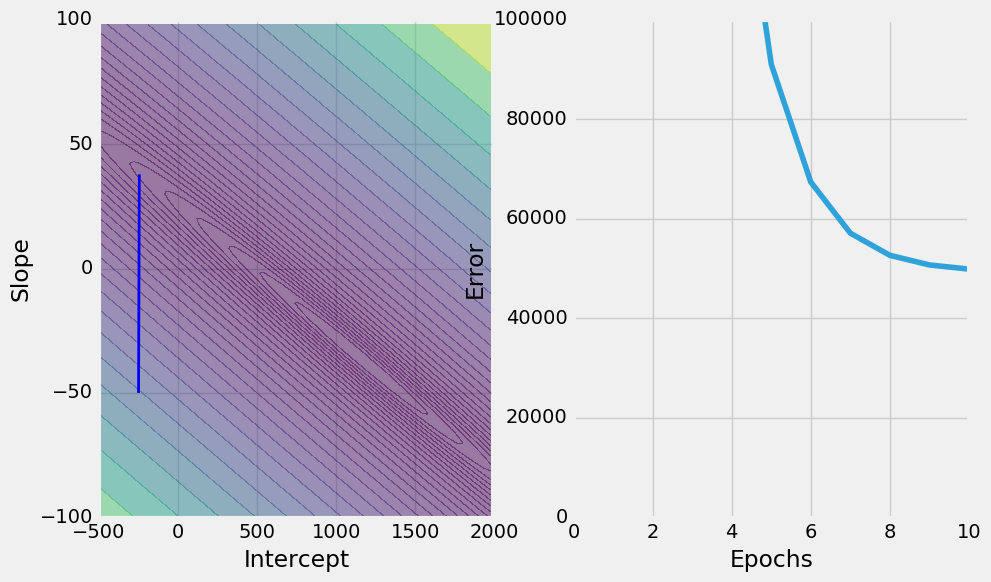

In [32]:
plot_gradient_descent(0.0005, 10, gradient_descent)

### Exercise
Plot with learning rate = 0.001, Epochs = 1000

Plot with learning rate = 0.002, Epochs = 10000

Plot with learning rate = 0.001, Epochs = 50000

## Challenges with Simple Gradient Descent


#### Convexity
In our linear regression problem, there was only one minimum. Our error surface was convex. Regardless of where we started, we would eventually arrive at the absolute minimum. In general, this need not be the case. It’s possible to have a problem with local minima that a gradient search can get stuck in. There are several approaches to mitigate this (e.g., stochastic gradient search).

#### Performance 
We used vanilla gradient descent with a learning rate of 0.001 in the above example, and ran it for 50000 iterations. There are approaches such a line search, that can reduce the number of iterations required and also avoid the overshooting problem with large learning rate.

#### Convergence 
We didn’t talk about how to determine when the search finds a solution. This is typically done by looking for small changes in error iteration-to-iteration (e.g., where the gradient is near zero).

## Line Search Gradient Descent

To avoid the problem of setting the learning rate and overshooting, we can adaptively choose the step size

$$ \beta_{i+1} = \beta_{i} - \eta * \nabla E(\beta)$$


First, fix a parameter $ 0 < β < 1$, then start with $\eta = 1$, and while


$$ E(\beta_{i+1}) >  E(\beta) - \frac{\eta}{2} * {||\nabla E(\beta)||}^2 $$

then

$$ \eta = \beta * \eta $$

Typically, we take $\beta = [0.1, 0.8] $

In [33]:
def gradient_descent_line (eta, epochs, X, y, n):
    
    beta = 0.5
    
    # Set Initial Values 
    b = np.asmatrix([[-250],[-50]])
    e = error(X,y,b,n)
    b0_all, b1_all, e_all = [], [], []
    b0_all.append(b.item(0)) 
    b1_all.append(b.item(1)) 
    e_all.append(e)

    # Run the calculation for those many epochs
    for i in range(epochs):
        e_old = error(X,y,b,n)
        g = gradient(X,y,b,n)
        b = b - eta * g
        e = error(X,y,b,n)
        #print(e,e_old)
        if e > e_old - eta/2*(g.T*g):
            eta = eta * beta
        
        b0_all.append(b.item(0)) 
        b1_all.append(b.item(1)) 
        e_all.append(e)
    
    return e_all, b0_all, b1_all

### Avoid Overshooting
Let see the performance difference between Simple Gradient Descent and Line Search Gradient Descent

In [43]:
exp1_e, exp1_b0, exp1_b1 = gradient_descent_line (1, 2000, X, y, n)
exp1_e[-1], exp1_b0[-1], exp1_b1[-1]

(40109.61884934987, -55.17888717921847, 29.001897775707313)

In [44]:
exp1_e, exp1_b0, exp1_b1 = gradient_descent (1, 2000, X, y, n)
exp1_e[-1], exp1_b0[-1], exp1_b1[-1]

/Users/amitkaps/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract


(nan, nan, nan)

### Plotting the Line Search Gradient Descent

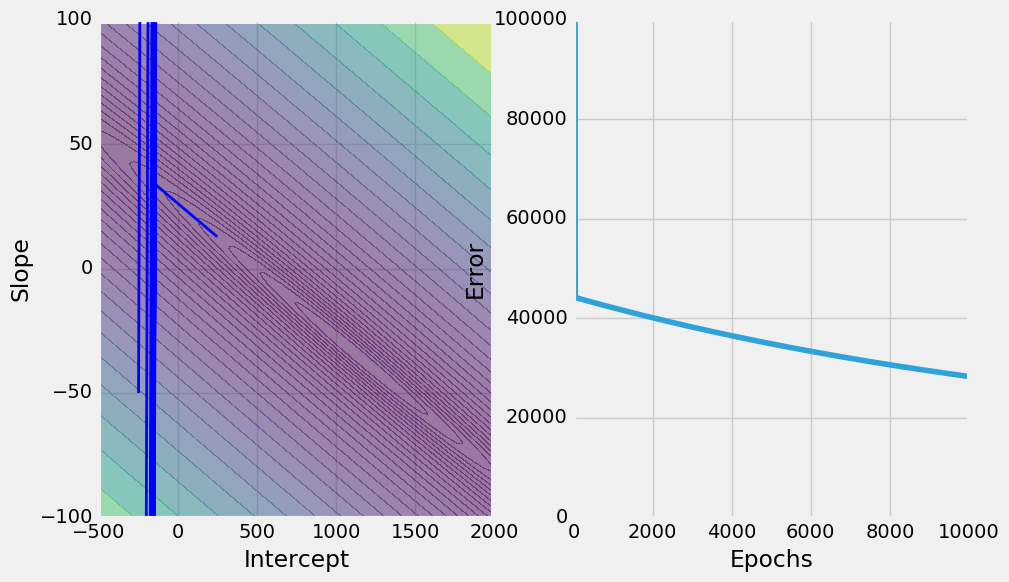

In [39]:
plot_gradient_descent(1, 10000, gradient_descent_line)